In [ ]:
#%%
import os
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle 
from matplotlib.colors import ListedColormap

from matplotlib.lines import Line2D

import openslide
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns

/rsrch5/home/plm/phacosta/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Processing: morph_emb + label_singleR ---

Adjusted Rand Index (ARI): 0.189
Normalized Mutual Information (NMI): 0.258


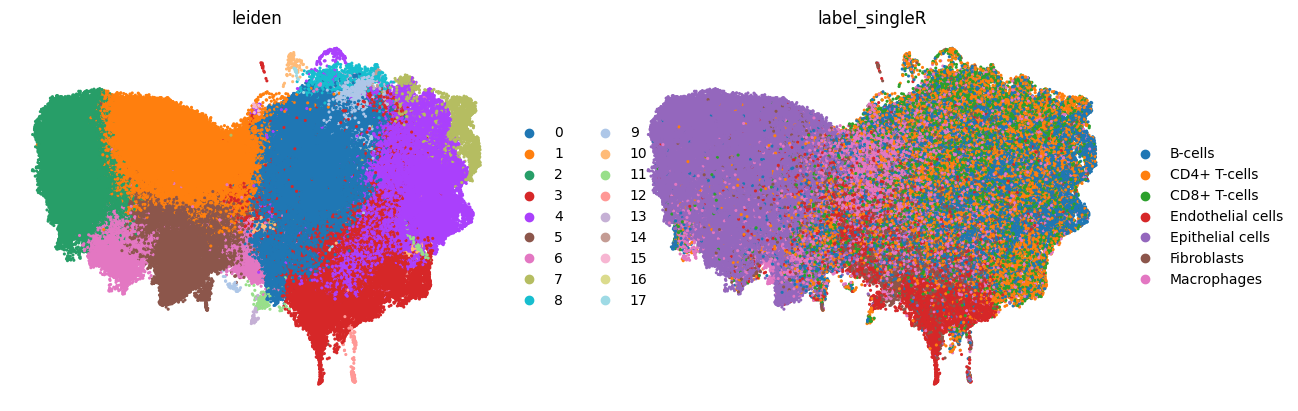

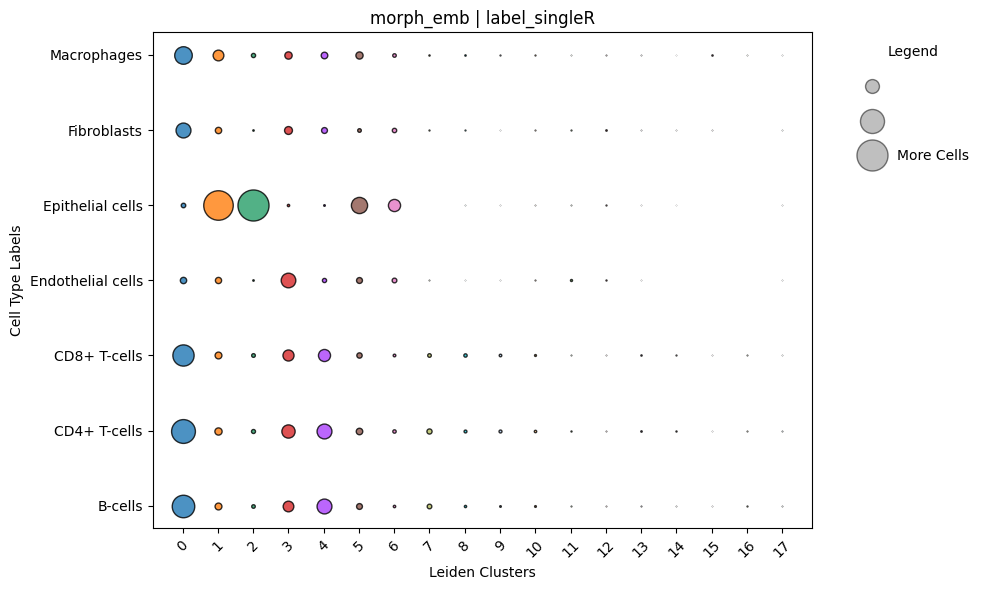

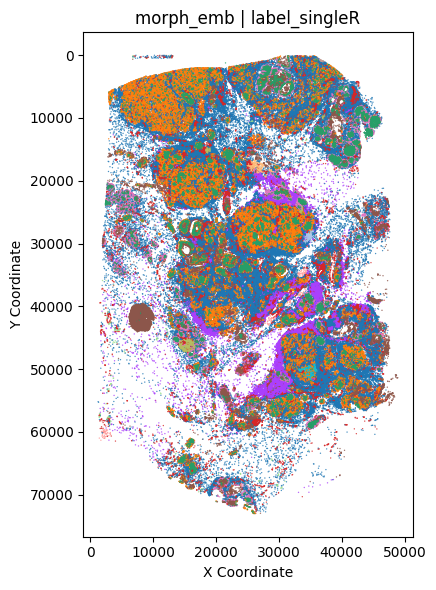

In [ ]:
#%%
# Settings
ground_truth = "refined"
level = 0
cancer = "breast"

xenium_folder_dict = {
    "lung": "Xenium_Prime_Human_Lung_Cancer_FFPE_outs",
    "breast": "Xenium_Prime_Breast_Cancer_FFPE_outs",
    "lymph_node": "Xenium_Prime_Human_Lymph_Node_Reactive_FFPE_outs",
    "prostate": "Xenium_Prime_Human_Prostate_FFPE_outs",
    "skin": "Xenium_Prime_Human_Skin_FFPE_outs",
    "ovarian": "Xenium_Prime_Ovarian_Cancer_FFPE_outs",
    "cervical": "Xenium_Prime_Cervical_Cancer_FFPE_outs"
}

xenium_folder = xenium_folder_dict[cancer]
embedding_dir = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/{xenium_folder}"
singleR_data_path = f"/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/{xenium_folder}/preprocessed/fine_tune_{ground_truth}_v2/processed_xenium_data_fine_tune_{ground_truth}_v2_annotated.h5ad"
# celltypist_data_path = f"/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/{xenium_folder}/preprocessed/fine_tune_{ground_truth}_v2/processed_xenium_data_fine_tune_{ground_truth}_ImmuneHigh_v2.h5ad"
gene_emb_path = f"{embedding_dir}/scGPT/scGPT_CP.h5ad"

# Set save path
save_path = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/enrichment/public_data/{xenium_folder}"
os.makedirs(save_path, exist_ok=True)

#%%
# Load AnnData with SingleR and CellTypist
adata_singleR = sc.read_h5ad(singleR_data_path)
# adata_celltypist = sc.read_h5ad(celltypist_data_path)

# Merge cell data
adata = adata_singleR.copy()
cell_data = adata.obs.copy()
# cell_data["majority_voting"] = adata_celltypist.obs["majority_voting"]
# cell_data["qc_celltypist"] = adata_celltypist.obs.get("qc_celltypist")

# Use raw labels
cell_data["label_singleR"] = cell_data["singleR_class"]
# cell_data["label_celltypist"] = cell_data["majority_voting"]
cell_data["label_aistil"] = adata.obs.get("class", pd.Series(index=cell_data.index))

# Spatial coordinates
spatial_coords = cell_data[['x_centroid', 'y_centroid']].rename(columns={'x_centroid': 'x', 'y_centroid': 'y'})

#%%
# Load embeddings
morph_embedding_csv = os.path.join(embedding_dir, "UNI2_cell_representation", f"level_{level}", "uni2_pretrained_embeddings.csv") # morphology_embeddings_v2
morph_embeddings = pd.read_csv(morph_embedding_csv, index_col="Unnamed: 0")

gdata = sc.read_h5ad(gene_emb_path)
gene_embeddings = pd.DataFrame(gdata.obsm["X_scGPT"], index=gdata.obs_names)

# Load contrastive embeddings
gene_proj = pd.read_csv(os.path.join(embedding_dir, "contrastive_learning", "gene_projection_embeddings_v2.csv"), index_col=0)
morph_proj = pd.read_csv(os.path.join(embedding_dir, "contrastive_learning", "morph_projection_embeddings_v2.csv"), index_col=0)
joint_emb = pd.read_csv(os.path.join(embedding_dir, "contrastive_learning", "joint_embeddings_v2.csv"), index_col=0)

# Reindex all embeddings to match cell_data
gene_embeddings = gene_embeddings.reindex(cell_data.index)
morph_embeddings = morph_embeddings.reindex(cell_data.index)
gene_proj = gene_proj.reindex(cell_data.index)
morph_proj = morph_proj.reindex(cell_data.index)
joint_emb = joint_emb.reindex(cell_data.index)
spatial_coords = spatial_coords.reindex(cell_data.index)

# Drop cells with no usable labels
cell_data = cell_data[
    cell_data["label_singleR"].notnull() |
    # cell_data["label_celltypist"].notnull() |
    cell_data["label_aistil"].notnull()
]

#%% Functions

# Clustering + Evaluation
def leiden_and_evaluate(
    embedding_df,
    labels_series,
    resolution=0.40,
    n_neighbors=15,
    label_name="true_label",
    target_classes=None,
    umap_legend="right margin",
    emb_name=None,
    label_source=None,
    save_path=None
):
    adata = sc.AnnData(embedding_df.values, obs=pd.DataFrame(index=embedding_df.index))
    adata.obs[label_name] = labels_series.loc[embedding_df.index]

    if target_classes is not None:
        adata = adata[adata.obs[label_name].isin(target_classes)].copy()

        # target_set = set(target_classes)
        # adata.obs[label_name] = adata.obs[label_name].apply(
        #     lambda x: x if x in target_set else "other"
        #     )   


    adata = adata[adata.obs[label_name].notnull()].copy()

    sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X')
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution)

    # Plot and save UMAP
    fig = sc.pl.umap(
        adata,
        color=['leiden', label_name],
        size=20,
        legend_loc=umap_legend,
        frameon=False,
        show=False,  # <-- important for saving
        return_fig=True
    )
    if save_path and emb_name and label_source:
        fig.savefig(os.path.join(save_path, f"umap_{emb_name}_{label_source}.png"), dpi=300)
        adata.write(os.path.join(save_path, f"{emb_name}_adata.h5ad"))

    ari = adjusted_rand_score(adata.obs[label_name], adata.obs['leiden'])
    nmi = normalized_mutual_info_score(adata.obs[label_name], adata.obs['leiden'])

    print(f"\nAdjusted Rand Index (ARI): {ari:.3f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

    return adata



# Dot Plot

def plot_cluster_label_dotplot(
    adata,
    cluster_key="leiden",
    label_key="label_singleR",
    target_classes=None,
    figsize=(10, 6),
    cmap="tab20",
    title="Cluster vs Cell Type Dot Plot",
    cluster_color_map=None,
    save_path=None,
    emb_name=None,
    label_source=None
):
    if target_classes is not None:
        adata = adata[adata.obs[label_key].isin(target_classes)].copy()

    count_matrix = pd.crosstab(adata.obs[label_key], adata.obs[cluster_key])
    max_val = count_matrix.values.max()
    clusters = count_matrix.columns.astype(str)

    if cluster_color_map is None:
        colormap = plt.get_cmap(cmap, len(clusters))
        cluster_color_map = {cl: colormap(i) for i, cl in enumerate(clusters)}

    fig, ax = plt.subplots(figsize=figsize)
    for i, label in enumerate(count_matrix.index):
        for j, cluster in enumerate(clusters):
            value = count_matrix.loc[label, cluster]
            size = (value / max_val) * 500
            ax.scatter(j, i, s=size, color=cluster_color_map[cluster], alpha=0.8, edgecolors='black')

    ax.set_xticks(range(len(clusters)))
    ax.set_xticklabels(clusters, rotation=45)
    ax.set_yticks(range(len(count_matrix.index)))
    ax.set_yticklabels(count_matrix.index)
    ax.set_xlabel("Leiden Clusters")
    ax.set_ylabel("Cell Type Labels")
    ax.set_title(title)

    example_sizes = [100, 300, 500]
    size_labels = ["", "", "More Cells"]
    size_handles = [
        Line2D([], [], marker='o', linestyle='None',
               markersize=np.sqrt(s), color='gray', alpha=0.5, markeredgecolor='black',
               label=lab)
        for s, lab in zip(example_sizes, size_labels)
    ]
    ax.legend(handles=size_handles, title="Legend", frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left', labelspacing=1.5)

    plt.tight_layout()

    if save_path and emb_name and label_source:
        fig.savefig(os.path.join(save_path, f"dotplot_{emb_name}_{label_source}.png"), dpi=300)

    plt.show()

def plot_spatial_clusters(
    adata,
    spatial_coords,
    cluster_key="leiden",
    cmap="tab20",
    s=1,
    figsize=(8, 6),
    title="Spatial Visualization of Clusters",
    cluster_color_map=None,
    save_path=None,
    emb_name=None,
    label_source=None,
):
    """
    Draw a scatter plot of spatial clusters and write three files if a
    save_path is supplied:
        1.  ...png  – full plot with axes / title (as before)
        2.  ..._clean.png  – no text / axes
        3.  ..._clean_gray.tif  – clean version, clusters in discrete gray levels
    """
    # ------------------------------------------------------------------
    # Prepare coordinates and colours
    # ------------------------------------------------------------------
    coords = spatial_coords.loc[adata.obs_names]
    adata.obs["x"] = coords["x"]
    adata.obs["y"] = coords["y"]

    clusters = sorted(adata.obs[cluster_key].astype(int).unique())
    n_clusters = len(clusters)

    if cluster_color_map is None:
        base_cmap = plt.get_cmap(cmap, n_clusters)
        cluster_color_map = {str(cl): base_cmap(i) for i, cl in enumerate(clusters)}

    cluster_colors = adata.obs[cluster_key].astype(str).map(cluster_color_map)

    # ------------------------------------------------------------------
    # Helper – draw scatter to a supplied Axes
    # ------------------------------------------------------------------
    def _scatter(ax, colors):
        ax.scatter(
            adata.obs["x"],
            adata.obs["y"],
            c=colors,
            s=s,
            alpha=0.8,
            edgecolors="none",
        )
        ax.invert_yaxis()
        ax.set_aspect("equal")

    # ------------------------------------------------------------------
    # Full plot (show + save)
    # ------------------------------------------------------------------
    fig_full, ax_full = plt.subplots(figsize=figsize)
    _scatter(ax_full, cluster_colors)
    ax_full.set_xlabel("X Coordinate")
    ax_full.set_ylabel("Y Coordinate")
    ax_full.set_title(title)
    plt.tight_layout()

    if save_path and emb_name and label_source:
        root = f"spatial_{emb_name}_{label_source}"
        # (a) full PNG
        fig_full.savefig(os.path.join(save_path, f"{root}.png"), dpi=300)
    plt.show()

    # ------------------------------------------------------------------
    # Clean version (no text / axes) – coloured PNG
    # ------------------------------------------------------------------
    if save_path and emb_name and label_source:
        fig_clean, ax_clean = plt.subplots(figsize=figsize)
        _scatter(ax_clean, cluster_colors)
        ax_clean.set_axis_off()
        fig_clean.subplots_adjust(0, 0, 1, 1)            # tight border
        fig_clean.savefig(
            os.path.join(save_path, f"{root}_clean.png"),
            dpi=300,
            bbox_inches="tight",
            pad_inches=0,
        )
        plt.close(fig_clean)

        # --------------------------------------------------------------
        # Clean grayscale version – TIFF
        # --------------------------------------------------------------
        # Map every cluster to a unique gray level between 0 and 1
        gray_levels = np.linspace(0, 1, n_clusters)
        gray_map = {str(cl): (g, g, g) for cl, g in zip(clusters, gray_levels)}
        gray_colors = adata.obs[cluster_key].astype(str).map(gray_map)

        fig_gray, ax_gray = plt.subplots(figsize=figsize)
        _scatter(ax_gray, gray_colors)
        ax_gray.set_axis_off()
        fig_gray.subplots_adjust(0, 0, 1, 1)
        fig_gray.savefig(
            os.path.join(save_path, f"{root}_clean_gray.tif"),
            dpi=300,
            format="tiff",
            bbox_inches="tight",
            pad_inches=0,
        )
        plt.close(fig_gray)

    # ------------------------------------------------------------------
    # Return paths (optional convenience)
    # ------------------------------------------------------------------
    if save_path and emb_name and label_source:
        return {
            "full_png":   os.path.join(save_path, f"{root}.png"),
            "clean_png":  os.path.join(save_path, f"{root}_clean.png"),
            "clean_tif":  os.path.join(save_path, f"{root}_clean_gray.tif"),
        }


#%% Reference Cells 
##################################
# Single R cell types 
##################################
# ['CD4+ T-cells',
#  'CD8+ T-cells',
#  'NK cells',
#  'B-cells',
#  'Epithelial cells',
#  'Macrophages',
#  'Monocytes',
#  'Chondrocytes',
#  'Myocytes',
#  'Fibroblasts',
#  'Eosinophils',
#  'Melanocytes',
#  'Smooth muscle',
#  'Endothelial cells',
#  'HSC',
#  'Adipocytes',
#  'Neutrophils',
#  'DC',
#  'Erythrocytes',
#  'Astrocytes',
#  'Mesangial cells',
#  'Keratinocytes',
#  'Pericytes',
#  'Skeletal muscle',
#  'Neurons']

#%%
# Example: morph_proj vs SingleR, filtered to a few target classes
target_singleR = ['CD4+ T-cells',
                'CD8+ T-cells',
                'B-cells',
                'Epithelial cells',
                'Macrophages',
                'Fibroblasts',
                'Endothelial cells',
                # "other"
                ]

target_aistil = [
    "t",         # tumor
    "f",         # fibroblast
    "l",         # lymphocyte
    "o",         # other
]

# emb_dict = {"gene_proj":gene_proj, "morph_proj": morph_proj, "gene_emb":gene_embeddings, "morph_emb":morph_embeddings, }
emb_dict = {"morph_emb":morph_embeddings, }

# label_dict = {"label_singleR": target_singleR, "label_aistil":target_aistil}
label_dict = {"label_singleR": target_singleR}


#%% Run clustering + plotting across all embeddings and label types

if cancer == "lung": res = 0.5
elif cancer == "prostate": res = 0.45
elif cancer == "breast": res = 0.40

for emb_name, emb_data in emb_dict.items():
    for label_source, target_classes in label_dict.items():
        # if np.logical_and(emb_name == "gene_emb", label_source=="singleR"):
        #     continue
        print(f"\n--- Processing: {emb_name} + {label_source} ---")

            
        emb_adata = leiden_and_evaluate(
            emb_data,
            cell_data[label_source],
            resolution=res,
            label_name=label_source,
            target_classes=target_classes,
            umap_legend="right margin",
            emb_name=emb_name,
            label_source=label_source,
            save_path=save_path
        )

        if cancer == "prostate":
            leiden_ids = sorted(emb_adata.obs["leiden"].astype(int).unique())
            original_colors = emb_adata.uns["leiden_colors"].copy()

            # Map cluster ID to its index in the color list
            id_to_index = {str(i): idx for idx, i in enumerate(leiden_ids)}

            # Define your custom colors
            custom_colors = {
                "0": "#4daf4a",   # green
                "1": "#377eb8",   # blue
                "2": "#ff7f00",   # orange
            }

            # Apply the overrides to the original color list
            for cluster_id, new_color in custom_colors.items():
                if cluster_id in id_to_index:
                    original_colors[id_to_index[cluster_id]] = new_color

            # Save updated colors back to the AnnData object
            emb_adata.uns["leiden_colors"] = original_colors

            # Create a mapping from cluster ID to color for plotting functions
            cluster_color_map = {str(i): color for i, color in zip(leiden_ids, original_colors)}

        else:
            leiden_palette = emb_adata.uns["leiden_colors"]
            leiden_ids = sorted(emb_adata.obs["leiden"].astype(int).unique())
            cluster_color_map = {str(i): c for i, c in zip(leiden_ids, leiden_palette)}

        plot_cluster_label_dotplot(
            emb_adata,
            cluster_key="leiden",
            label_key=label_source,
            target_classes=target_classes,
            cmap="tab20",
            cluster_color_map=cluster_color_map,
            title=f"{emb_name} | {label_source}",
            save_path=save_path,
            emb_name=emb_name,
            label_source=label_source
        )

        plot_spatial_clusters(
            emb_adata,
            spatial_coords,
            cluster_key="leiden",
            cmap="tab20",
            cluster_color_map=cluster_color_map,
            title=f"{emb_name} | {label_source}",
            save_path=save_path,
            emb_name=emb_name,
            label_source=label_source
        )